#### Copyright 2020 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Regression Project

We have learned about regression and how to build regression models using both scikit-learn and TensorFlow. Now we'll build a regression model from start to finish. We will acquire data and perform exploratory data analysis and data preprocessing. We'll build and tune our model and measure how well our model generalizes.

## Framing the Problem

### Overview

*Friendly Insurance, Inc.* has requested we do a study for them to help predict the cost of their policyholders. They have provided us with sample [anonymous data](https://www.kaggle.com/mirichoi0218/insurance) about some of their policyholders for the previous year. The dataset includes the following information:

Column   | Description
---------|-------------
age      | age of primary beneficiary
sex      | gender of the primary beneficiary (male or female)
bmi      | body mass index of the primary beneficiary
children | number of children covered by the plan
smoker   | is the primary beneficiary a smoker (yes or no)
region   | geographic region of the beneficiaries (northeast, southeast, southwest, or northwest)
charges  | costs to the insurance company

We have been asked to create a model that, given the first six columns, can predict the charges the insurance company might incur.

The company wants to see how accurate we can get with our predictions. If we can make a case for our model, they will provide us with the full dataset of all of their customers for the last ten years to see if we can improve on our model and possibly even predict cost per client year over year.

### Exercise 1: Thinking About the Data

Before we dive in to looking closely at the data, let's think about the problem space and the dataset. Consider the questions below.

#### Question 1

Is this problem actually a good fit for machine learning? Why or why not?

##### **Student Solution**

> *Yes this problem is a good fit for machine learning because based on past data we can make predictions on company costs. use the data provided to guess costs. Given these constraints we can weigh each input accordingly and apply a model and test how accurate our model is in predicting costs.

---

#### Question 2

If we do build the machine learning model, what biases might exist in the data? Is there anything that might cause the model to have trouble generalizing to other data? If so, how might we make the model more resilient?

##### **Student Solution**

> *Some biases in the data may include limiting the amount of children options as a family with more children may pay more per child. The model may have trouble generalizing to other data due to no spcifications of the type of insurance plan. Including type and what is included based on needs or illness can help specify the charges.*

---

#### Question 3

We have been asked to take input features about people who are insured and predict costs, but we haven't been given much information about how these predictions will be used. What effect might our predictions have on decisions made by the insurance company? How might this affect the insured?

##### **Student Solution**

> *Our predictions made could cause the insurance to unfairly charge more to a certain group when it is not nessecary or it could cause the the insurance to think they do not have to pay as much leaving more individuals to pay out of pocket when they shouldn't.*

---

## Exploratory Data Analysis

Now that we have considered the societal implications of our model, we can start looking at the data to get a better understanding of what we are working with.

The data we'll be using for this project can be [found on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Upload your `kaggle.json` file and run the code block below.

In [ ]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

### Exercise 2: EDA and Data Preprocessing

Using as many code and text blocks as you need, download the dataset, explore it, and do any model-independent preprocessing that you think is necessary. Feel free to use any of the tools for data analysis and visualization that we have covered in this course so far. Be sure to do individual column analysis and cross-column analysis. Explain your findings.

#### **Student Solution**

##### Import Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
from collections import Counter

with zipfile.ZipFile('insurance.zip','r') as z:
  z.extractall('./')
os.listdir()

insurance_df = pd.read_csv('insurance.csv')
insurance_df

#### Import TensorFlow

In [ ]:
%tensorflow_version 2.x

import tensorflow as tf
tf.__version__

##### Missing Data

In [ ]:
# No missing data
insurance_df.isnull().all()

##### Examine Data and Correlations

In [ ]:
for region in sorted(insurance_df['region'].unique()):
  print(region)

insurance_df.describe()

In [ ]:
import seaborn as sns

corr_axes = []
for i in range(len(insurance_df.corr())):
  corr_axes.append(insurance_df.corr().columns[i])

sns.heatmap(
    insurance_df.corr(),
    yticklabels=corr_axes,
    xticklabels=corr_axes,
    cmap='coolwarm',
)

##### Features and Targets

In [ ]:
target_column = 'charges'
feature_columns = [c for c in insurance_df.columns if c != target_column]
numeric_feature_columns = [c for c in feature_columns if c != 'sex' and c != 'smoker' and c != 'region']

target_column, feature_columns, numeric_feature_columns

##### Standardize Data

In [ ]:
insurance_df.loc[:, numeric_feature_columns] = (
    insurance_df[numeric_feature_columns] - 
      insurance_df[numeric_feature_columns].mean()) / (
          insurance_df[numeric_feature_columns].std())

insurance_df[numeric_feature_columns].describe()

##### Features and Targets

In [ ]:
target_column = 'charges'
feature_columns = [c for c in insurance_df.columns if c != target_column]
numeric_feature_columns = [c for c in feature_columns if c != 'sex' and c != 'smoker' and c != 'region']

target_column, feature_columns, numeric_feature_columns

##### One-Hot Encoding

In [ ]:
# sex
for op in sorted(insurance_df['sex'].unique()):
  op_col = op.lower().replace(' ', '_').replace('<', '')
  insurance_df[op_col] = (insurance_df['sex'] == op).astype(int)
  feature_columns.append(op_col)

feature_columns.remove('sex')

# smoker
for op in sorted(insurance_df['smoker'].unique()):
  op_col = op.lower().replace(' ', '_').replace('<', '')
  insurance_df[op_col] = (insurance_df['smoker'] == op).astype(int)
  feature_columns.append(op_col)

feature_columns.remove('smoker')

# regions
for op in sorted(insurance_df['region'].unique()):
  op_col = op.lower().replace(' ', '_').replace('<', '')
  insurance_df[op_col] = (insurance_df['region'] == op).astype(int)
  feature_columns.append(op_col)

feature_columns.remove('region')

insurance_df

---

## Modeling

Now that we understand our data a little better, we can build a model. We are trying to predict 'charges', which is a continuous variable. We'll use a regression model to predict 'charges'.

Using as many code and text blocks as you need, build a model that can predict 'charges' given the features that we have available. To do this, feel free to use any of the toolkits and models that we have explored so far.

You'll be expected to:
1. Prepare the data for the model (or models) that you choose. Remember that some of the data is categorical. In order for your model to use it, you'll need to convert the data to some numeric representation.
1. Build a model or models and adjust parameters.
1. Validate your model with holdout data. Hold out some percentage of your data (10-20%), and use it as a final validation of your model. Print the root mean squared error. We were able to get an RMSE between `3500` and `4000`, but your final RMSE will likely be different.

### Exercise 3: Modeling

#### **Student Solution**

##### Shuffle and Split Data

In [ ]:
# Shuffle
insurance_df = insurance_df.sample(frac=1)

# Calculate test set size
test_set_size = int(len(insurance_df) * 0.2)

# Split the data
testing_df = insurance_df[:test_set_size]
training_df = insurance_df[test_set_size:]

print(f'Holding out {len(testing_df)} records for testing. ')
print(f'Using {len(training_df)} records for training.')

##### Create Model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Create the Sequential model.
model = keras.Sequential()

# Determine the "input shape", which is the number
# of features that we will feed into the model.
input_shape = len(feature_columns)

# Create a layer that accepts our features and outputs
# a single value, the predicted median home price.
layer = layers.Dense(1, input_shape=[input_shape])

# Add the layer to our model.
model.add(layer)

# Print out a model summary with the only 1 layer.

model = keras.Sequential(layers=[
    layers.Dense(
        1,
        input_shape=[len(feature_columns)],
        # Name your layer here
        name = 'the_only_layer'
    )
])

model.summary()

##### Activation Function

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

feature_count = len(feature_columns)

model = keras.Sequential([
  layers.Dense(100, input_shape=[feature_count], activation='exponential'),
  layers.Dense(100, activation='exponential'),
  layers.Dense(1)
])

model.summary()

##### Compile

In [ ]:
model.compile(
  loss='mse',
  optimizer='Adam',
  metrics=['mae', 'mse'],
)

model.summary()

##### EPOCHS

In [ ]:
EPOCHS = 100

model.fit(
  training_df[feature_columns],
  training_df[target_column],
  epochs=EPOCHS,
  validation_split=0.2,
)

##### Predictions

In [ ]:
predictions = model.predict(testing_df[feature_columns])

predictions

##### RMSE

In [ ]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(predictions, testing_df[target_column], squared=False)

RMSE

###### **Image of our best result**

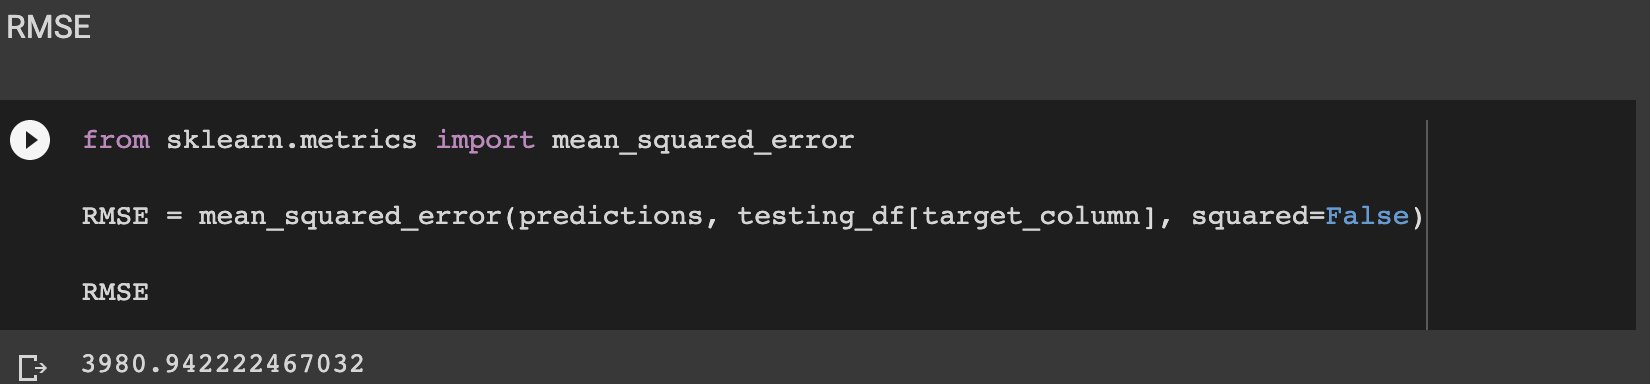